In [1]:
# Imports and plotting setups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math

import math_funcs

from scipy.constants import (
    epsilon_0,   # Permittivity of free space (vacuum)
    mu_0,        # Permeability of free space (vacuum)
    c,           # Speed of light in vacuum
    #e,           # Elementary charge
    #h,           # Planck constant
    #hbar,        # Reduced Planck constant (h-bar)
    k,           # Boltzmann constant
    #G,           # Newtonian constant of gravitation
    #m_e,         # Electron mass
    #m_p,         # Proton mass
    #m_n,         # Neutron mass
    #alpha,       # Fine-structure constant
    eV,          # Electron volt
)

from transmission_reflection_coefficients import transmissivity_fBm, reflectivity_fBm
from T_B_Europan_sky import angle_grid

In [11]:
# Magic number constants
# Low band
f = 5.373e6
epsilon_i_prime = 1
epsilon_t_prime = 2.76
H = 0.75
sigma_ref = 0.2
sigma = sigma_ref * (c/f)**(H)

# Course grid settings
ag = angle_grid(10, 10)

flat_shape = ag.theta_grid.flatten().shape[0]
twoD_shape = ag.theta_grid.shape

sigma, flat_shape, twoD_shape

(4.083033022841862, 703, (19, 37))

In [53]:
(flat_shape, *twoD_shape)

(703, 19, 37)

In [79]:
def calc_gamma_ab(
    f, epsilon_i_prime, epsilon_t_prime, 
    sigma, H, bistatic_polarization):
    
    gamma_ab = np.zeros((flat_shape, twoD_shape[0]))
    theta_i_values = np.deg2rad(ag.theta.flatten())
    theta_t_values = np.deg2rad(ag.theta_grid.flatten())
    phi_t_values = np.deg2rad(ag.phi_grid.flatten())

    for t in np.arange(flat_shape):
        theta_t = theta_t_values[t]
        phi_t = theta_t_values[t]
        if theta_t < np.pi/2:
            for i in np.arange(twoD_shape[0]):
                theta_i = theta_i_values[i]
                if theta_i < np.pi/2:
                    gamma_ab[t, i] = np.nan_to_num(transmissivity_fBm(
                            f = f, # Hz
                            epsilon_i_prime = epsilon_i_prime,
                            epsilon_t_prime = epsilon_t_prime,
                            sigma_A = sigma,
                            H = H,
                            theta_i = theta_i,
                            theta_t = np.pi - theta_t,
                            phi_t = phi_t,
                            bistatic_polarization= bistatic_polarization
                        ))
    return gamma_ab

T_Bv_i = np.ones(twoD_shape)
T_Bh_i = np.ones(twoD_shape)

def integrate_gamma_ab_and_T_Ba_i(
        T_Bv_i, T_Bh_i,
        f, epsilon_i_prime, epsilon_t_prime, 
        sigma, H, x
):
    d_solid_angle = \
        np.sin(np.deg2rad(ag.theta.flatten()))[None, :, None] \
            * np.deg2rad(ag.dtheta) * np.deg2rad(ag.dphi)

    gamma_ab_helper = lambda x: calc_gamma_ab(
        f, epsilon_i_prime, epsilon_t_prime, 
        sigma, H, x
    )
    # The gamma_ab function returns a function thats 
    # flattened along the transmitted angle grid
    # and has values in its 3rd (index =2) dimension  
    # representing incident theta. As gamma_ab is 
    # symmetric in phi, there is no 4th (index=3) dimension. 
    # To get the transmitted radiation (T_ba)
    # multiply the incident radiation (T_Bb) 
    # against the incident pattern theta pattern. 
    # To do this add a phi axis [:,:,None] to gamma_ab pattern
    # so the T_Bb pattern broadcasts along that axis (phi axis), 
    # then add an axis to the front of T_Bb [None, :, :] 
    # so we multiply incident radiation by incident gamma pattern.
    # The last two axis of expression 
    # 'gamma_ab_helper('vv')[:,:,None] * T_Bv[None,:,:]' 
    # represent the contribution of incident radiation 
    # to the transmitted angle described by the first axis.
    # By summing the last two axis using np.sum (---, (-1, -2)) 
    # the total contribution at every transmitted angle is found.
    T_Bv = gamma_ab_helper('vv')[:,:,None] * T_Bv_i[None,:,:] 
    T_Bv += gamma_ab_helper('vh')[:,:,None] * T_Bh_i[None,:,:]
    T_Bv = np.sum(T_Bv * d_solid_angle, (-1, -2)) / (4 * np.pi)

    T_Bh = gamma_ab_helper('hh')[:,:,None] * T_Bh_i[None,:,:] 
    T_Bh += gamma_ab_helper('hv')[:,:,None] * T_Bv_i[None,:,:]
    T_Bh = np.sum(T_Bh * d_solid_angle, (-1, -2)) / (4 * np.pi)

    return T_Bv, T_Bh

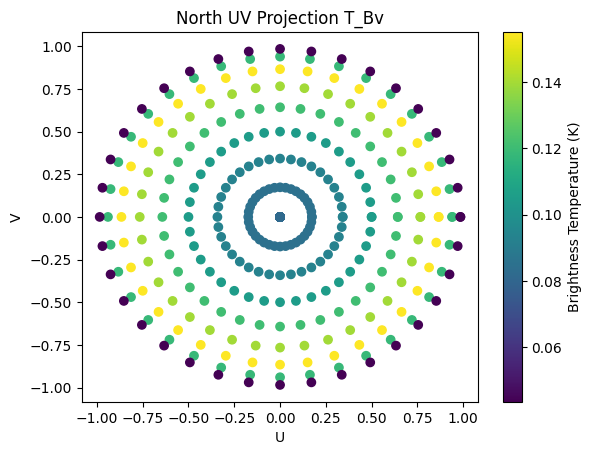

In [80]:
# Plot only the Northern Hemisphere of the brightness temperature
U = (np.sin(np.deg2rad(ag.theta_grid[0:9])) * np.cos(np.deg2rad(ag.phi_grid[0:9]))).flatten()
V = (np.sin(np.deg2rad(ag.theta_grid[0:9])) * np.sin(np.deg2rad(ag.phi_grid[0:9]))).flatten()

plt.figure()
plt.scatter(U, V, c=T_Bv.reshape(twoD_shape)[0:9].flatten()
    , cmap='viridis')
plt.colorbar(label='Brightness Temperature (K)')
plt.xlabel('U')
plt.ylabel('V')
plt.title('North UV Projection T_Bv')
plt.show()

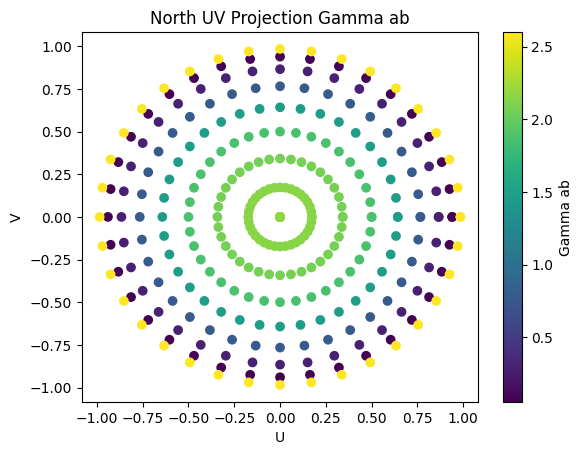

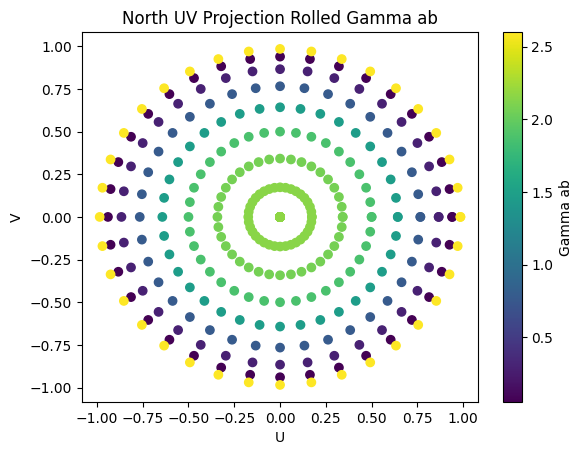

In [48]:
def calc_gamma_ab(
    f, epsilon_i_prime, epsilon_t_prime, 
    sigma, H, bistatic_polarization):
    
    gamma_ab = np.zeros(flat_shape)

    theta_t_values = np.deg2rad(ag.theta.flatten())

    theta_i_values = np.deg2rad(ag.theta_grid.flatten())
    phi_i_values = np.deg2rad(ag.phi_grid.flatten())

    for t in np.arange(twoD_shape[0]):
        theta_t = theta_t_values[t]
        if theta_t < np.pi/2:
            for i in np.arange(flat_shape):
                theta_i = theta_i_values[i]
                phi_i = phi_i_values[i]
                if theta_i < np.pi/2:
                    gamma_ab[i] = np.nan_to_num(transmissivity_fBm(
                            f = f, # Hz
                            epsilon_i_prime = epsilon_i_prime,
                            epsilon_t_prime = epsilon_t_prime,
                            sigma_A = sigma,
                            H = H,
                            theta_i = theta_i,
                            phi_t = phi_i,
                            theta_t = np.pi - theta_t,
                            bistatic_polarization= bistatic_polarization
                        ))
    # Sum all the gamma_abs along the phi axis
    temp = np.sum(gamma_ab.reshape(twoD_shape), -1)
    # Copy the theta axis only pattern back into a circle
    gamma_ab = np.repeat(temp, twoD_shape[-1])
    # Then reflatten gamma_ab for return
    gamma_ab = gamma_ab.flatten()
    return gamma_ab

T_Bv = calc_gamma_ab('vv') * T_Bv * ag.dtheta * ag.dphi + \
    calc_gamma_ab('vh') * T_Bh * ag.dtheta * ag.dphi
T_Bh = calc_gamma_ab('hh') * T_Bh * ag.dtheta * ag.dphi+ \
    calc_gamma_ab('hv') * T_Bv * ag.dtheta * ag.dphi

In [ ]:
gamma_ab = calc_gamma_ab('hh')
# Plot only the Northern Hemisphere of the brightness temperature
U = (np.sin(np.deg2rad(ag.theta_grid[0:9])) * np.cos(np.deg2rad(ag.phi_grid[0:9]))).flatten()
V = (np.sin(np.deg2rad(ag.theta_grid[0:9])) * np.sin(np.deg2rad(ag.phi_grid[0:9]))).flatten()

plt.figure()
plt.scatter(U, V, c=gamma_ab.reshape(twoD_shape)[0:9].flatten()
    , cmap='viridis')
plt.colorbar(label='Gamma ab')
plt.xlabel('U')
plt.ylabel('V')
plt.title('North UV Projection Gamma ab')
plt.show()

In [77]:
# Integrate the transmitted field by summing to find transmitted field over all incident fields
    # Low band
sigma = sigma_ref * (3e8/5.373e6)**(H)
vertical_bistatic_polarizations = ['vv', 'hv']
horizontal_bistatic_polarizations = ['hh', 'vh']

brightness_field_of_europan_sky_vertical = \
    np.ones(flat_shape)
brightness_field_of_europan_sky_horizontal = \
    np.ones(flat_shape)

brightness_temperature_vertical_low_band = np.zeros_like(ag.theta_grid).flatten()
brightness_temperature_horizontal_low_band = np.zeros_like(ag.theta_grid).flatten()

theta_t_values = np.deg2rad(ag.theta_grid.flatten())
phi_t_values = np.deg2rad(ag.phi_grid.flatten())

theta_i_values = np.deg2rad(ag.theta_grid.flatten())
phi_i_values = np.deg2rad(ag.phi_grid.flatten())

dtheta = np.deg2rad(10)
dphi = np.deg2rad(10)

for t in np.arange(flat_shape):
    theta_t = theta_t_values[t]
    phi_t = phi_t_values[t]

    for i in np.arange(flat_shape):
        theta_i = theta_i_values[i]
        phi_i = phi_i_values[i]
        
        if theta_t < np.pi/2 and theta_i < np.pi/2:
            gamma_vv = np.nan_to_num(transmissivity_fBm(
                    f = f, # Hz
                    epsilon_i_prime = epsilon_i_prime,
                    epsilon_t_prime = epsilon_t_prime,
                    sigma_A = sigma,
                    H = H,
                    theta_i = theta_i,
                    phi_t = phi_t - phi_i,
                    theta_t = theta_t,
                    bistatic_polarization='vv'
                ))

            gamma_vh = np.nan_to_num(transmissivity_fBm(
                    f = f, # Hz
                    epsilon_i_prime = epsilon_i_prime,
                    epsilon_t_prime = epsilon_t_prime,
                    sigma_A = sigma,
                    H = H,
                    theta_i = theta_i,
                    phi_t = phi_t - phi_i,
                    theta_t = theta_t,
                    bistatic_polarization='vh'
                ))
            
            gamma_hh = np.nan_to_num(transmissivity_fBm(
                    f = f, # Hz
                    epsilon_i_prime = epsilon_i_prime,
                    epsilon_t_prime = epsilon_t_prime,
                    sigma_A = sigma,
                    H = H,
                    theta_i = theta_i,
                    phi_t = phi_t - phi_i,
                    theta_t = theta_t,
                    bistatic_polarization='hh'
                ))            

            gamma_hv = np.nan_to_num(transmissivity_fBm(
                    f = f, # Hz
                    epsilon_i_prime = epsilon_i_prime,
                    epsilon_t_prime = epsilon_t_prime,
                    sigma_A = sigma,
                    H = H,
                    theta_i = theta_i,
                    phi_t = phi_t - phi_i,
                    theta_t = theta_t,
                    bistatic_polarization='hv'
                ))


            brightness_temperature_vertical_low_band[t] += gamma_vv * brightness_field_of_europan_sky_vertical[i] * dtheta * dphi + \
                gamma_vh * brightness_field_of_europan_sky_horizontal[i] * dtheta * dphi
            brightness_temperature_horizontal_low_band[t] += gamma_hh * brightness_field_of_europan_sky_horizontal[i] * dtheta * dphi+ \
                gamma_hv * brightness_field_of_europan_sky_vertical[i] * dtheta * dphi

brightness_temperature_vertical_low_band = np.sin(ag.theta_grid.flatten()) * brightness_temperature_vertical_low_band / (4 * np.pi)
brightness_temperature_vertical_low_band = brightness_temperature_vertical_low_band.reshape(ag.theta_grid.shape)

brightness_temperature_horizontal_low_band = np.sin(ag.theta_grid.flatten()) * brightness_temperature_horizontal_low_band / (4 * np.pi)
brightness_temperature_horizontal_low_band = brightness_temperature_horizontal_low_band.reshape(ag.theta_grid.shape)

e:\Jake Sahli\Documents\Git\Europan_Cryosphere_Puck_Estimator\transmission_reflection_coefficients.py:199: RuntimeWarning: divide by zero encountered in log
  + 2 * n * np.log(eta_xy) \


In [84]:
brightness_temperature_horizontal_low_band

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  

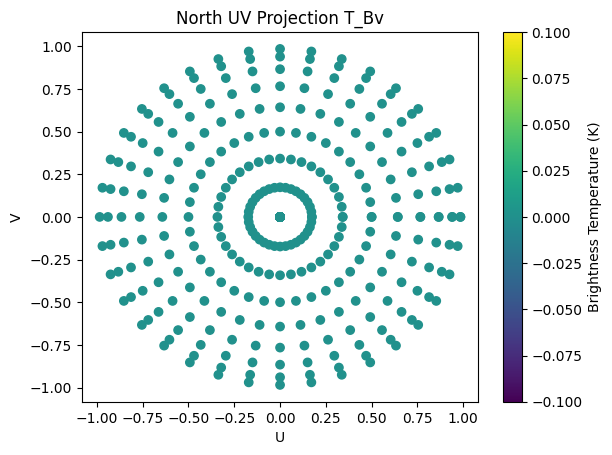

In [82]:
# Plot only the Northern Hemisphere of the brightness temperature
U = (np.sin(np.deg2rad(ag.theta_grid[10:])) * np.cos(np.deg2rad(ag.phi_grid[10:]))).flatten()
V = (np.sin(np.deg2rad(ag.theta_grid[10:])) * np.sin(np.deg2rad(ag.phi_grid[10:]))).flatten()

plt.figure()
plt.scatter(U, V, c=brightness_temperature_horizontal_low_band.reshape(twoD_shape)[10:].flatten()
    , cmap='viridis')
plt.colorbar(label='Brightness Temperature (K)')
plt.xlabel('U')
plt.ylabel('V')
plt.title('North UV Projection T_Bv')
plt.show()